# **Import the libraries**

In [14]:
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Created by Umar Abdul Hakim Robbani

# **Load Datasets**

In [15]:
drive.mount('/content/drive')


df = pd.read_csv('Combined Data.csv')
print(df.head)
df = df.drop(df.columns[0], axis = 1)
print(df.head())
print(f"unik : {df['status'].unique()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of        Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to g

# **Visualize Data**
Count the total of each states value and separate those to different columns so the status data could be visualized.

info: status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


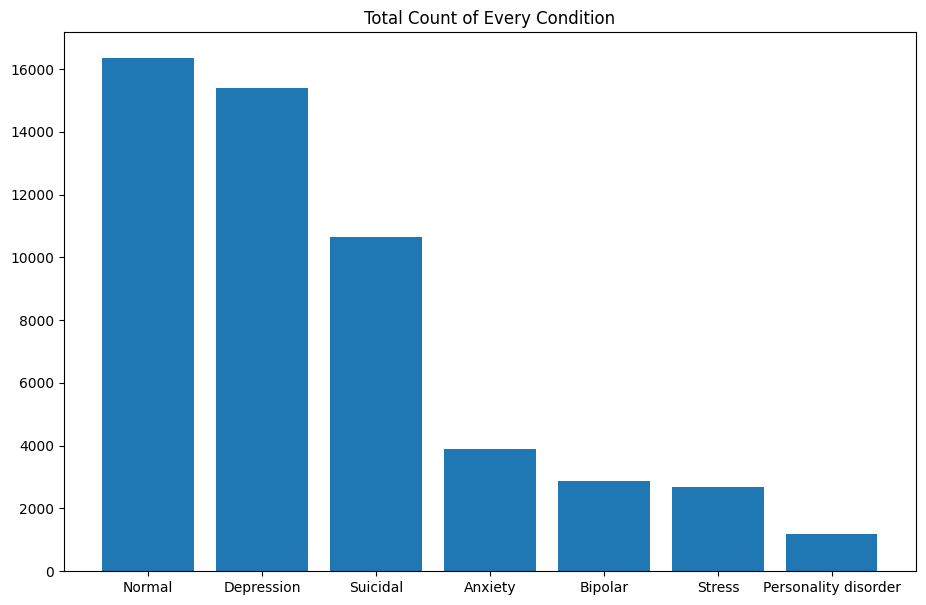

In [16]:
status_recorded = df['status'].value_counts() # Count the total of each values in columns 'status'
status_recorded = status_recorded.reset_index() # Reset the index so we could create new columns
status_recorded.columns = ['Status', 'Count'] # Assign status to first column and the other one to second column
plt.figure(figsize=(11, 7))
plt.bar(status_recorded['Status'], status_recorded['Count']) # Visualize the status recorded
plt.title('Total Count of Every Condition')
print(f"info: {df['status'].value_counts()}")
plt.show()

Visualize of common words that represent the status - condition.

Percentages of Thank word appeared: 6.05%
Percentages of Nice word appeared: 2.34%
Percentages of Doubt word appeared: 0.97%
Percentages of Worried word appeared: 2.53%


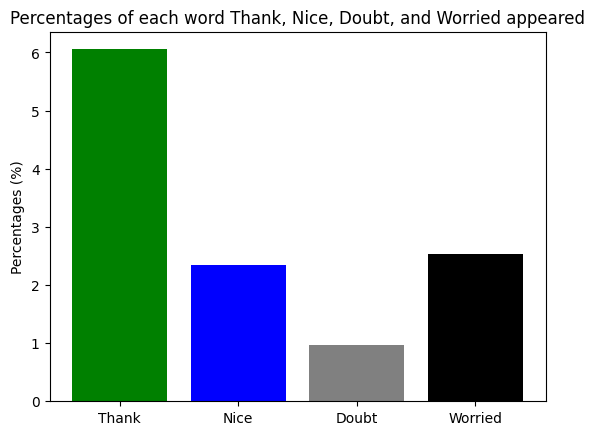

In [17]:
Thank = (df[(df.statement.str.contains("Thank", na= False))].shape[0]/len(df)) * 100
thank = (df[(df.statement.str.contains("thank", na= False))].shape[0]/len(df)) * 100 + Thank
nice = (df[(df.statement.str.contains("nice", na= False))].shape[0]/len(df)) * 100
Nice = (df[(df.statement.str.contains("Nice", na= False))].shape[0]/len(df)) * 100 + nice
doubt = (df[(df.statement.str.contains("doubt", na= False))].shape[0]/len(df)) * 100
Doubt = (df[(df.statement.str.contains("Doubt", na= False))].shape[0]/len(df)) * 100 + doubt
worried = (df[(df.statement.str.contains("worried", na= False))].shape[0]/len(df)) * 100
Worried = (df[(df.statement.str.contains("Worried", na= False))].shape[0]/len(df)) * 100 + worried

labels = ['Thank', 'Nice', 'Doubt', 'Worried']
values = [thank, Nice, Doubt, Worried]
plt.bar(labels, values, color = ['Green', 'Blue', 'Grey', 'Black'])
plt.title('Percentages of each word Thank, Nice, Doubt, and Worried appeared')
plt.ylabel('Percentages (%)')
print(f"Percentages of Thank word appeared: {thank:.2f}%")
print(f"Percentages of Nice word appeared: {Nice:.2f}%")
print(f"Percentages of Doubt word appeared: {Doubt:.2f}%")
print(f"Percentages of Worried word appeared: {Worried:.2f}%")
plt.show()

# **Data Preparation**
We map the status columns as the key with the integer value from 0 to 6 for categorical classification.

In [18]:
mapping = {
  'Normal': 0,
  'Depression': 1,
  'Suicidal': 2,
  'Anxiety': 3,
  'Bipolar': 4,
  'Stress': 5,
  'Personality disorder': 6
}

df['status'] = df['status'].map(mapping)
X = df['statement'].astype(str)
y = df['status']



After that we splid the data with ration between train, cv, and test = 99/0.5/0.5

In [19]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.01, random_state=37)
X_test, X_cv, y_test, y_cv = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=37)

And then tokenize the words from the X_train, X_cv and X_test

In [20]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_cv_sequences = tokenizer.texts_to_sequences(X_cv)
# print(f"X seq = {X_train_sequences}")

max_length = 150
X_train_pad = pad_sequences(X_train_sequences, maxlen = max_length)
X_test_pad = pad_sequences(X_test_sequences, maxlen = max_length)
X_cv_pad = pad_sequences(X_cv_sequences, maxlen = max_length)
print(f"X_train_pad: {X_train_pad}")

X_train_pad: [[   0    0    0 ...    2  260 2971]
 [   0    0    0 ...   22 6965   69]
 [   0    0    0 ...   53  193 3188]
 ...
 [   0    0    0 ...   15   10  248]
 [  35    1   14 ...    1   24  415]
 [   0    0    0 ...  111  103 2108]]


In [21]:
sm = SMOTE(random_state=42)
X_train_pad, y_train = sm.fit_resample(X_train_pad, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# **Model Processing**
And then build the architecture with:
1. Embedding layer with 100 x 128 input dimension and regularization value = 1x10^-1000
2. Three bidirectional LSTM RNN with the first couple of those using parameter return_sequences= True so it uses all from each timestep as the output.
3. Fully connected layer with 7 units and softmax activation used with input from LSTM and gives the categorical output.

Model compiled with Sparse CategoricalCrossentropy so it gives categorical value between 0 - 6 like we mapped before, also with adam optimizer and accuracy metrics.

Model trained with X_train and the target label y_train with 10 epochs, 16 batch_size, and validation set from X_cv & y_cv. The epochs is for gradient descent to work, batch_size to use parallel processing, and the CV (Cross Validation) to enhance the algorithm with the unseen data in the gradient descent process.
```
# This is formatted as code
```



In [22]:
# model = Sequential(
#   [
#     Embedding(10000, 128, embeddings_regularizer= l2(0.003)),
#     Bidirectional(LSTM(128, return_sequences= True)),
#     Bidirectional(LSTM(128, return_sequences = True)),
#     Bidirectional(LSTM(128, return_sequences = True)),
#     Bidirectional(LSTM(128)),
#     Dense(7, activation = 'softmax')
#   ]
# )

# model.compile(
#   loss = SparseCategoricalCrossentropy(from_logits= False),
#   optimizer = Adam(0.001),
#   metrics = ['accuracy']
# )

# history = model.fit(
#   X_train_pad, y_train,
#   epochs = 15,
#   batch_size = 32,
#   validation_data = (X_cv_pad, y_cv),
# )
model = load_model('/content/drive/My Drive/Datasets/Health Analysis/model1_8.keras')

Epoch 1/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 208s 57ms/step - accuracy: 0.3929 - loss: 1.6280 - val_accuracy: 0.5827 - val_loss: 0.9756
Epoch 2/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 200s 56ms/step - accuracy: 0.4753 - loss: 1.3446 - val_accuracy: 0.6504 - val_loss: 0.8651
Epoch 3/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 199s 56ms/step - accuracy: 0.5154 - loss: 1.2620 - val_accuracy: 0.7143 - val_loss: 0.8568
Epoch 4/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 201s 55ms/step - accuracy: 0.5530 - loss: 1.1874 - val_accuracy: 0.7293 - val_loss: 0.7391
Epoch 5/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 205s 56ms/step - accuracy: 0.5689 - loss: 1.1469 - val_accuracy: 0.7632 - val_loss: 0.6932
Epoch 6/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 204s 57ms/step - accuracy: 0.5822 - loss: 1.1117 - val_accuracy: 0.7669 - val_loss: 0.7037
Epoch 7/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 199s 56ms/step - accuracy: 0.5953 - loss: 1.0817 - val_accuracy: 0.7594 - val_loss: 0.7112
Epoch 8/15
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 200s 56ms/step - accuracy: 

Save model and model weight

In [23]:
# model.save('/content/drive/My Drive/Datasets/Health Analysis/model1_8.keras')
# model.save_weights('/content/drive/My Drive/Datasets/Health Analysis/model_weights1_8.weights.h5')

# **Performance Test**
Model Evaluation using X_test and y_test

In [24]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7931 - loss: 0.8312
Test Accuracy: 80.38%


Using F1 Score

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
F1 Score for Normal: 93.49%
F1 Score for Depression: 72.44%
F1 Score for Suicidal: 74.78%
F1 Score for Anxiety: 81.36%
F1 Score for Bipolar: 86.67%
F1 Score for Stress: 58.33%
F1 Score for Personality disorder: 33.33%


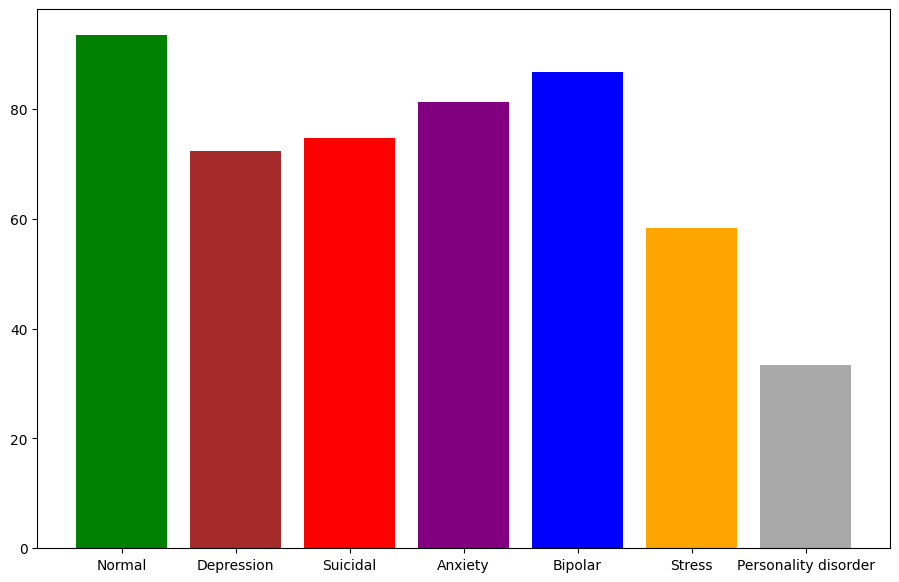

In [25]:
y_predict = np.argmax(model.predict(X_test_pad), axis = 1)
f_score = f1_score(y_test, y_predict, average = None)
classes = list(mapping.keys())

for classes, fscore in zip(classes, f_score):
  print(f"F1 Score for {classes}: {fscore * 100:.2f}%")

classes = list(mapping.keys())

plt.figure(figsize = (11, 7))
plt.bar(classes, f_score*100, color = ['green', 'brown', 'red', 'purple', 'blue', 'orange', 'darkgrey'])
plt.show()